# Use simulation to study reasons behind the inflation of QQ plot
1. Select regions and simulate phenotypes.
2. Take the index SNPs and run heterogeneity test.
3. Evaluate the heterogeneity statistics.

In [1]:
%load_ext autoreload
%load_ext lab_black
%autoreload 2


import numpy as np
import pandas as pd
import pickle
import xarray as xr
import admix
import matplotlib.pyplot as plt
import statsmodels.api as sm
from tqdm import tqdm
from os.path import join
import sys

sys.path.append("../../")
import common

In [2]:
# read dataset and do minimal processing
dset_gwas_hit = xr.open_zarr("out/locus_het/gwas_hit.zarr/", chunks=-1)
admix.tools.af_per_anc(dset_gwas_hit)
maf = np.minimum(
    dset_gwas_hit["af_per_anc"].values, 1 - dset_gwas_hit["af_per_anc"].values
).min(axis=1)
dset_gwas_hit = dset_gwas_hit.sel(snp=maf > 0.01)

# load hm3 data set
dset_hm3 = common.load_page_hm3()

100%|██████████| 22/22 [00:00<00:00, 67.22it/s]


In [3]:
df_gwas_hit = dset_gwas_hit.snp.to_dataframe().iloc[::10, :]

In [4]:
import pickle
import os
from scipy import stats
from admix.data import quantile_normalize

In [52]:
dict_df_plot = {
    "test_snp_rank": [],
    "sim_i": [],
    "min_att": [],
    "min_tractor": [],
}
for n in ["snp", "att", "het", "tractor"]:
    dict_df_plot[f"test_{n}"] = []
    dict_df_plot[f"causal_{n}"] = []


for region_i in range(50):
    file_name = f"out/het_simulation/region_{region_i}.pkl"
    if not os.path.exists(file_name):
        print(f"Missing region {region_i}")
        continue

    with open(file_name, "rb") as f:
        region_rls = pickle.load(f)

    for test_snp_rank in region_rls:
        for sim_i, rls in enumerate(region_rls[test_snp_rank]):
            dict_df_plot["test_snp_rank"].append(test_snp_rank)
            dict_df_plot["sim_i"].append(sim_i)
            test_snp = rls["test_snp"]
            dict_df_plot["test_snp"].append(test_snp)
            dict_df_plot["test_att"].append(rls["att"].P.values[test_snp])
            dict_df_plot["test_tractor"].append(rls["tractor"].P.values[test_snp])
            dict_df_plot["test_het"].append(rls["test_het_pval"])

            causal_snp = rls["causal_snp"]
            mask = np.full(len(rls["att"]), True)
            mask[causal_snp] = False
            dict_df_plot["causal_snp"].append(causal_snp)
            dict_df_plot["causal_att"].append(rls["att"].P.values[causal_snp])
            dict_df_plot["causal_het"].append(rls["causal_het_pval"])
            dict_df_plot["causal_tractor"].append(rls["tractor"].P.values[causal_snp])
            dict_df_plot["min_att"].append(np.min(rls["att"].P.values[mask]))
            dict_df_plot["min_tractor"].append(np.min(rls["tractor"].P.values[mask]))

In [53]:
df_plot = pd.DataFrame(dict_df_plot)

<ipython-input-60-76feca4ce077>:2: RuntimeWarning: divide by zero encountered in log10
  -np.log10(df_plot.min_att.values), -np.log10(df_plot.min_tractor.values), alpha=0.1


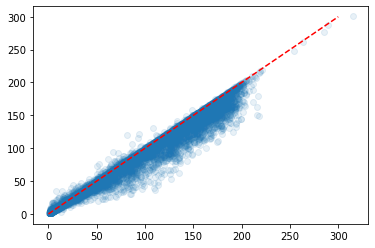

In [60]:
plt.scatter(
    -np.log10(df_plot.min_att.values), -np.log10(df_plot.min_tractor.values), alpha=0.1
)
plt.plot([0, 300], [0, 300], "r--")

lambda GC: 840
lambda GC: 773


/u/project/pasaniuc/kangchen/admix-tools/admix/plot/_plot.py:52: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(-np.log10(expected_pval), -np.log10(pval), s=2, label=label)


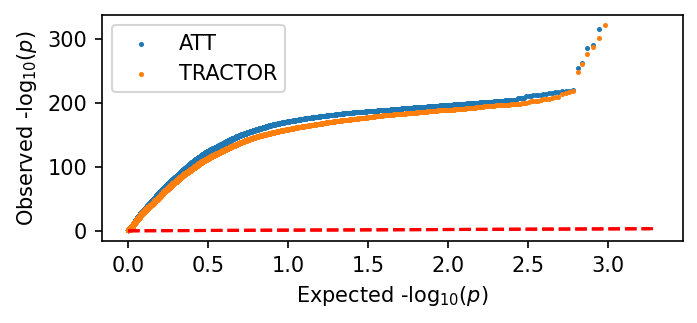

In [55]:
fig, ax = plt.subplots(figsize=(5, 2), dpi=150)
admix.plot.qq(df_plot.min_att.values, ax=ax, label="ATT")
admix.plot.qq(df_plot.min_tractor.values, ax=ax, label="TRACTOR")
plt.legend()

HET test at SNPs with association rank: 0
lambda GC: 0.985 [0.911, 1.06]
Proportion of tested SNPs are causal SNPs: 0.7128
------------------------------------------
HET test at SNPs with association rank: 1
lambda GC: 1.4 [1.28, 1.55]
Proportion of tested SNPs are causal SNPs: 0.1036
------------------------------------------
HET test at SNPs with association rank: 3
lambda GC: 1.67 [1.54, 1.81]
Proportion of tested SNPs are causal SNPs: 0.028
------------------------------------------
HET test at SNPs with association rank: 5
lambda GC: 2.07 [1.84, 2.25]
Proportion of tested SNPs are causal SNPs: 0.0088
------------------------------------------
lambda GC: 0.986 [0.906, 1.09]
lambda GC: 1.04 [0.965, 1.13]
lambda GC: 0.973 [0.893, 1.07]
lambda GC: 0.894 [0.829, 0.984]


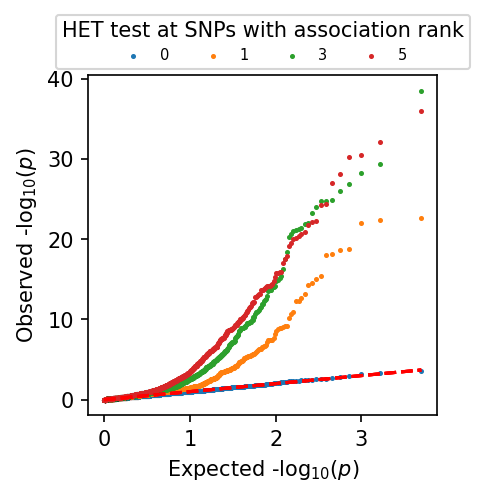

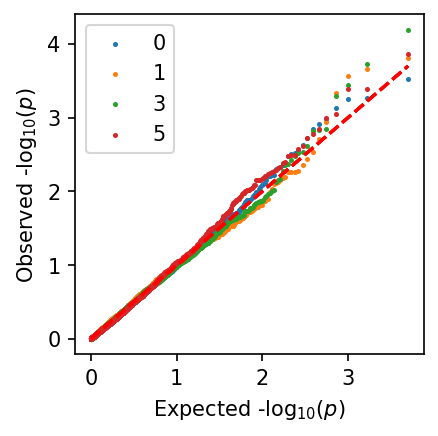

In [62]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
for test_snp_rank in df_plot.test_snp_rank.unique():
    df_tmp = df_plot[df_plot.test_snp_rank == test_snp_rank]
    print(f"HET test at SNPs with association rank: {test_snp_rank}")

    admix.plot.qq(df_tmp.test_het.values, label=test_snp_rank, bootstrap_ci=True)
    print(
        f"Proportion of tested SNPs are causal SNPs: {np.mean(df_tmp.test_snp == df_tmp.causal_snp)}"
    )
    print("------------------------------------------")


plt.legend(
    title="HET test at SNPs with association rank",
    ncol=4,
    loc="upper center",
    fontsize=7,
    bbox_to_anchor=(0.5, 1.2),
)

fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
for test_snp_rank in df_plot.test_snp_rank.unique():
    admix.plot.qq(
        df_plot[df_plot.test_snp_rank == test_snp_rank].causal_het.values,
        label=test_snp_rank,
        bootstrap_ci=True,
    )
plt.legend()

lambda GC: 959
lambda GC: 881


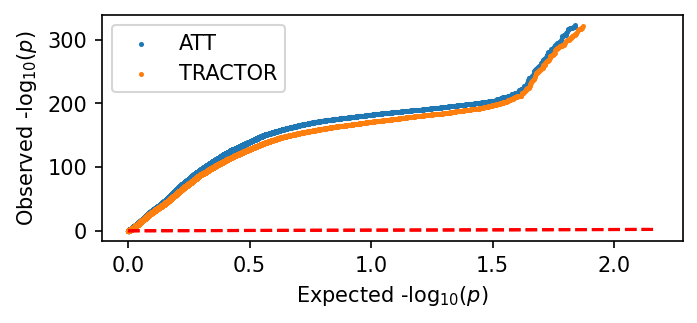

In [12]:
fig, ax = plt.subplots(figsize=(5, 2), dpi=150)
admix.plot.qq(df_plot.causal_att.values, ax=ax, label="ATT")
admix.plot.qq(df_plot.causal_tractor.values, ax=ax, label="TRACTOR")
plt.legend()

In [ ]:
#     fig, ax = plt.subplots(figsize=(5, 2), dpi=150, sharex=True)
#     admix.plot.manhattan(pval=assoc.P, axh_y=-np.log10(0.05 / len(assoc)))
#     index_snp = np.where(sim_beta[:, 0])[0].item()
#     ax.scatter(index_snp, -np.log10(assoc.P[index_snp]), s=20, marker="*")
#     plt.tight_layout()
#     plt.show()

# Simulate beta heterogeneity effect sizes
Use two practices with / without conditioning local ancestry

In [ ]:
np.random.seed(1234)
n_sim = 5

dict_rls = {"snp_i": [], "effect": [], "sim_i": [], "method": [], "pval": []}

cov = np.column_stack([dset.coords[col + "@indiv"].values for col in ["age", "sex"] + [f"geno_EV{i}" for i in range(1, 10)]])
allele_per_anc = dset["allele_per_anc"].values
lanc = dset.lanc.sum(axis=2).values

for snp_i in tqdm(range(dset.dims["snp"])):
# for snp_i in tqdm(range(10)):
    apa_snp = allele_per_anc[:, snp_i, :]
    lanc_snp = lanc[:, snp_i]
    for effect in [0.15, 0.2, 0.25]:
        pvals1 = []
        pvals2 = []
        
        for sim_i in range(n_sim):
            y_sim = simulate(apa_snp, [effect, 0.25], cov)
            # w/o conditioning
            pval1, model1 = test_het(apa_snp, y_sim, cov)
            pvals1.append(pval1)
            # w conditioning
#             pval2, model2 = test_het(apa_snp, sm.OLS(y_sim, sm.add_constant(lanc_snp)).fit().resid, cov)
            pval2, model2 = test_het(apa_snp, y_sim, np.column_stack([cov, lanc_snp]))
            pvals2.append(pval2)
        for method, pvals in zip(["w/o lanc", "w lanc"], [pvals1, pvals2]):
            dict_rls["pval"].extend(pvals)
            dict_rls["method"].extend([method] * n_sim)
            dict_rls["sim_i"].extend(np.arange(n_sim))
            dict_rls["effect"].extend([effect] * n_sim)
            dict_rls["snp_i"].extend([snp_i] * n_sim)

df_rls = pd.DataFrame(dict_rls)

In [ ]:
np.random.seed(1234)
n_sim = 10

allele_per_anc = dset["allele_per_anc"].values
lanc = dset.lanc.sum(axis=2).values

diff_corr = []
for snp_i in tqdm(range(dset.dims["snp"])):
    apa_snp = allele_per_anc[:, snp_i, :]
    lanc_snp = lanc[:, snp_i]
    
    df_corr = pd.DataFrame(np.column_stack([apa_snp, lanc_snp]), columns=["EUR", "AFR", "lanc"]).corr()
    diff_corr.append(df_corr.iloc[1, 2] - df_corr.iloc[0, 2])

In [ ]:
df_corr

In [ ]:
f = dset["af_per_anc"].values
df_af = pd.DataFrame({"snp_i": np.arange(af.shape[0]), "EUR_af": af[:, 0], "AFR_af": af[:, 1], "diff_corr": diff_corr})

df_plot = pd.merge(df_rls, df_af, on="snp_i")
df_plot["diff_af"] = df_plot["EUR_af"] - df_plot["AFR_af"]

In [ ]:
df_plot.groupby(["method", "effect"]).agg({"pval": lambda x : np.mean(x < 0.05)})

In [ ]:
gt = np.dstack([dict_hit_info[snp]["gt"] for snp in dict_hit_info])

In [ ]:
gt = np.dstack([dict_hit_info[snp]["gt"] for snp in dict_hit_info])
sample = [dict_hit_info[snp]["sample"] for snp in dict_hit_info]
assert all(x == sample[0] for x in sample)
sample = sample[0]

R2 = [dict_hit_info[snp]["info"]["R2"] for snp in dict_hit_info]
AF = [dict_hit_info[snp]["info"]["AF"] for snp in dict_hit_info]

dset_gwas_hit = xr.Dataset(
    data_vars={
        "geno": (
            ("indiv", "snp", "ploidy"),
            da.from_array(np.swapaxes(gt, 1, 2), chunks=-1),
        ),
    },
    coords={
        "snp": np.array(list(dict_hit_info.keys())).astype(str),
        "indiv": np.array(sample).astype(str),
        "R2@snp": ("snp", np.array(R2, dtype=float)),
        "AF@snp": ("snp", np.array(AF, dtype=float)),
    },
    attrs={"n_anc": 2},
)

info = [s.split("_") for s in dset_gwas_hit.snp.values]
dset_gwas_hit = dset_gwas_hit.assign_coords(
    {
        "CHROM@snp": ("snp", [int(i[0]) for i in info]),
        "POS@snp": ("snp", [int(i[1]) for i in info]),
        "REF@snp": ("snp", [str(i[2]) for i in info]),
        "ALT@snp": ("snp", [str(i[3]) for i in info]),
    }
)

# align `dset_gwas_hit to `dset`
dset_gwas_hit = dset_gwas_hit.sel(indiv=dset.indiv.values)

# fill in lanc
df_dset = dset.snp.to_dataframe().reset_index(drop=True)
snp_index = []
for _, snp in tqdm(dset_gwas_hit.snp.to_dataframe().iterrows()):
    chrom, pos = snp["CHROM@snp"], snp["POS@snp"]
    df_tmp = df_dset[df_dset["CHROM@snp"] == chrom]
    snp_index.append((df_tmp["POS@snp"] - pos).abs().idxmin())
lanc = dset.isel(snp=snp_index).lanc.values
dset_gwas_hit = dset_gwas_hit.assign(
    lanc=(("indiv", "snp", "ploidy"), da.from_array(lanc, chunks=-1))
)

# fill in individual information
for col in dset:
    if col.endswith("@indiv"):
        dset_gwas_hit[col] = ("indiv", dset[col].values)
admix.tools.allele_per_anc(dset_gwas_hit)